In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-0d933040-01c6-3a0a-dad9-b09b3370f5a4)


In [ ]:
import torch
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
import os
import torch.nn as nn
import functools
import torchvision.transforms as transforms
from PIL import Image
import cv2

In [ ]:
def tensor2im(image_tensor, imtype=np.uint8):
	image_numpy = image_tensor[0].cpu().float().numpy()
	image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
	return image_numpy.astype(imtype)

In [ ]:
###############################################################################
# Functions
###############################################################################
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm2d') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=True)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def define_G(input_nc, output_nc, ngf, which_model_netG, norm='batch', use_dropout=False, gpu_ids=[], use_parallel=True,
             learn_residual=False):
    netG = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert (torch.cuda.is_available())

    if which_model_netG == 'resnet_9blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9,
                               gpu_ids=gpu_ids, use_parallel=use_parallel, learn_residual=learn_residual)
    elif which_model_netG == 'resnet_6blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6,
                               gpu_ids=gpu_ids, use_parallel=use_parallel, learn_residual=learn_residual)
    elif which_model_netG == 'unet_128':
        netG = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout,
                             gpu_ids=gpu_ids, use_parallel=use_parallel, learn_residual=learn_residual)
    elif which_model_netG == 'unet_256':
        netG = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout,
                             gpu_ids=gpu_ids, use_parallel=use_parallel, learn_residual=learn_residual)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % which_model_netG)
    if len(gpu_ids) > 0:
        netG.cuda()
    netG.apply(weights_init)
    return netG


def define_D(input_nc, ndf, which_model_netD, n_layers_D=3, norm='batch', use_sigmoid=False, gpu_ids=[],
             use_parallel=True):
    netD = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert (torch.cuda.is_available())
    if which_model_netD == 'basic':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid,
                                   gpu_ids=gpu_ids, use_parallel=use_parallel)
    elif which_model_netD == 'n_layers':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid,
                                   gpu_ids=gpu_ids, use_parallel=use_parallel)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % which_model_netD)
    if use_gpu:
        netD.cuda()
    netD.apply(weights_init)
    return netD


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)


##############################################################################
# Classes
##############################################################################


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(
            self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False,
            n_blocks=6, gpu_ids=[], use_parallel=True, learn_residual=False, padding_type='reflect'):
        assert (n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel
        self.learn_residual = learn_residual

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
            norm_layer(ngf),
            nn.ReLU(True)
        ]

        n_downsampling = 2


        model += [
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=use_bias),
            norm_layer(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=use_bias),
            norm_layer(256),
            nn.ReLU(True)
        ]

        for i in range(n_blocks):
            model += [
                ResnetBlock(256, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)
            ]

        model += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
            norm_layer(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=use_bias),
            norm_layer(64),
            nn.ReLU(True),
        ]

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            output = nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            output = self.model(input)
        if self.learn_residual:
            # output = input + output
            output = torch.clamp(input + output, min=-1, max=1)
        return output


# Define a resnet block
class ResnetBlock(nn.Module):

	def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
		super(ResnetBlock, self).__init__()

		padAndConv = {
			'reflect': [
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim, kernel_size=3, bias=use_bias)],
			'replicate': [
                nn.ReplicationPad2d(1),
                nn.Conv2d(dim, dim, kernel_size=3, bias=use_bias)],
			'zero': [
                nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=use_bias)]
		}

		try:
			blocks = padAndConv[padding_type] + [
				norm_layer(dim),
				nn.ReLU(True)
            ] + [
				nn.Dropout(0.5)
			] if use_dropout else [] + padAndConv[padding_type] + [
				norm_layer(dim)
			]
		except:
			raise NotImplementedError('padding [%s] is not implemented' % padding_type)

		self.conv_block = nn.Sequential(*blocks)

	def forward(self, x):
		out = x + self.conv_block(x)
		return out


# Defines the Unet generator.
# |num_downs|: number of downsamplings in UNet. For example,
# if |num_downs| == 7, image of size 128x128 will become of size 1x1
# at the bottleneck
class UnetGenerator(nn.Module):
    def __init__(
            self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d,
            use_dropout=False, gpu_ids=[], use_parallel=True, learn_residual=False):
        super(UnetGenerator, self).__init__()
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel
        self.learn_residual = learn_residual
        # currently support only input_nc == output_nc
        assert (input_nc == output_nc)

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, norm_layer=norm_layer, innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, unet_block, norm_layer=norm_layer,
                                                 use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, unet_block, outermost=True, norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            output = nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            output = self.model(input)
        if self.learn_residual:
            output = input + output
            output = torch.clamp(output, min=-1, max=1)
        return output


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(
            self, outer_nc, inner_nc, submodule=None,
            outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        dConv = nn.Conv2d(outer_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
        dRelu = nn.LeakyReLU(0.2, True)
        dNorm = norm_layer(inner_nc)
        uRelu = nn.ReLU(True)
        uNorm = norm_layer(outer_nc)

        if outermost:
            uConv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            dModel = [dConv]
            uModel = [uRelu, uConv, nn.Tanh()]
            model = [
                dModel,
                submodule,
                uModel
            ]
        # model = [
        # 	# Down
        # 	nn.Conv2d( outer_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=use_bias),
        #
        # 	submodule,
        # 	# Up
        # 	nn.ReLU(True),
        # 	nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1),
        # 	nn.Tanh()
        # ]
        elif innermost:
            uConv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            dModel = [dRelu, dConv]
            uModel = [uRelu, uConv, uNorm]
            model = [
                dModel,
                uModel
            ]
        # model = [
        # 	# down
        # 	nn.LeakyReLU(0.2, True),
        # 	# up
        # 	nn.ReLU(True),
        # 	nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias),
        # 	norm_layer(outer_nc)
        # ]
        else:
            uConv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=use_bias)
            dModel = [dRelu, dConv, dNorm]
            uModel = [uRelu, uConv, uNorm]

            model = [
                dModel,
                submodule,
                uModel
            ]
            model += [nn.Dropout(0.5)] if use_dropout else []

        # if use_dropout:
        # 	model = down + [submodule] + up + [nn.Dropout(0.5)]
        # else:
        # 	model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([self.model(x), x], 1)


# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[],
                 use_parallel=True):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        self.use_parallel = use_parallel

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = int(np.ceil((kw - 1) / 2))
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor) and self.use_parallel:
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)

In [ ]:
class BaseModel():
    def name(self):
        return 'BaseModel'

    def __init__(self):
        self.gpu_ids = '0'
        self.isTrain = False
        self.Tensor = torch.cuda.FloatTensor if self.gpu_ids else torch.Tensor
        self.save_dir = '/content/drive/MyDrive/sign_language/deblur_image_model/'

    def set_input(self, input):
        self.input = input

    def forward(self):
        pass

    # used in test time, no backprop
    def test(self):
        pass

    def get_image_paths(self):
        pass

    def optimize_parameters(self):
        pass

    def get_current_visuals(self):
        return self.input

    def get_current_errors(self):
        return {}

    def save(self, label):
        pass

    # helper loading function that can be used by subclasses
    def load_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.save_dir, save_filename)
        network.load_state_dict(torch.load(save_path))

    def update_learning_rate():
        pass

class TestModel(BaseModel):
    def name(self):
        return 'TestModel'

    def __init__(self):
        super(TestModel, self).__init__()
        self.input_A = self.Tensor(1, 3, 256, 256)

        self.netG = define_G(3, 3, 64,
                                      'resnet_9blocks', 'instance', False, ['0'], False,
                                      True)
        which_epoch = 'latest'
        self.load_network(self.netG, 'G', which_epoch)

        print('---------- Networks initialized -------------')

    def set_input(self, input):
        # we need to use single_dataset mode
        input_A = input
        temp = self.input_A.clone()
        temp.resize_(input_A.size()).copy_(input_A)
        self.input_A = temp

    def test(self):
        with torch.no_grad():
            self.real_A = Variable(self.input_A)
            self.fake_B = self.netG.forward(self.real_A)

    # get image paths
    def get_image_paths(self):
        return self.image_paths

    def get_current_visuals(self):
        real_A = tensor2im(self.real_A.data)
        fake_B = tensor2im(self.fake_B.data)
        return OrderedDict([('real_A', real_A), ('fake_B', fake_B)])

In [ ]:
transform_list = [transforms.Resize((256,256), Image.BICUBIC), transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))]
fct_trans = transforms.Compose(transform_list)

# Test

In [ ]:
mod = TestModel()

---------- Networks initialized -------------


In [ ]:
abs_path = '/content/drive/MyDrive/sign_language/data/'
path_vid = 'train/01August_2011_Monday_heute-4858.mp4'
vidcap = cv2.VideoCapture(abs_path + path_vid)

In [ ]:
success,image = vidcap.read()
count = 0
images = []
while success:
  images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

In [ ]:
x = fct_trans(Image.fromarray(images[0]))[None,:,:,:]

In [ ]:
mod.set_input(x)

In [ ]:
mod.test()
res = mod.get_current_visuals()

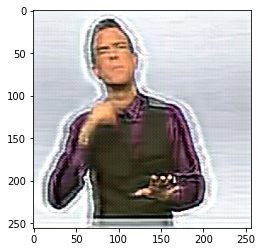

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(res['fake_B'])

FAIL !!!!!

FINAL ALTERNATIVE : https://github.com/VITA-Group/DeblurGANv2/blob/master/predict.py